In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")

os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['MUJOCO_GL']='egl'

%load_ext autoreload
%autoreload 2

from envs.maze_envs import CustomPointUMazeSize3Env, CustomAntUMazeSize3Env
source_env = CustomPointUMazeSize3Env()
target_env = CustomAntUMazeSize3Env()

source_env.reset(42, None)
target_env.reset(42, None)

(array([ 0.05479121, -0.01222431,  0.8217196 ,  0.99160886, -0.07742714,
         0.09074426,  0.049823  ,  0.05721286, -0.07437728, -0.00992281,
        -0.0258404 ,  0.08535299,  0.02877302,  0.06455232, -0.01131716,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  0.        ],
       dtype=float32),
 None)

In [2]:
print(source_env.observation_space.shape)
print(target_env.observation_space.shape)

(7,)
(30,)


In [3]:
## Source PointUMaze; Target AntUMaze
from datasets.dataset import Dataset

expert_source = np.load("/home/m_bobrin/CrossDomainIL/outputs/2024-04-04/21-13-01/saved_expert/trained_expert.npy", allow_pickle=True).item()
random_source = np.load("/home/m_bobrin/CrossDomainIL/outputs/2024-04-04/21-13-01/saved_prior/random_policy.npy", allow_pickle=True).item()
random_target = np.load("/home/m_bobrin/CrossDomainIL/outputs/2024-04-04/21-43-22/saved_prior/random_policy.npy", allow_pickle=True).item()

expert_source_ds = Dataset(observations=expert_source['observations'],
                           actions=expert_source['actions'],
                           rewards=expert_source['rewards'],
                           dones_float=expert_source['dones'],
                           masks=1.0 - expert_source['dones'],
                           next_observations=expert_source['next_observations'],
                           size=expert_source['observations'].shape[0])

non_expert_source_ds = Dataset(observations=random_source['observations'],
                           actions=random_source['actions'],
                           rewards=random_source['rewards'],
                           dones_float=random_source['dones'],
                           masks=1.0 - random_source['dones'],
                           next_observations=random_source['next_observations'],
                           size=random_source['observations'].shape[0])

agent_target_ds = Dataset(observations=random_target['observations'],
                           actions=random_target['actions'],
                           rewards=random_target['rewards'],
                           dones_float=random_target['dones'],
                           masks=1.0 - random_target['dones'],
                           next_observations=random_target['next_observations'],
                           size=random_target['observations'].shape[0])

(-0.5, 479.5, 479.5, -0.5)

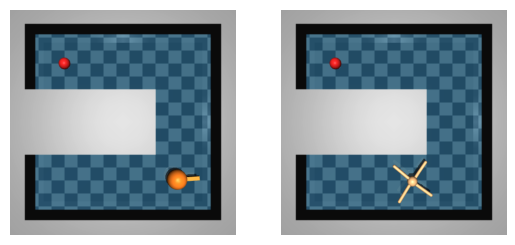

In [4]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
source_env.wrapped_env.set_xy(expert_source['observations'][30, :2])
target_env.wrapped_env.set_xy(random_target['observations'][500, :2])
axs[0].imshow(source_env.render('rgb_array'))
axs[1].imshow(target_env.render('rgb_array'))

axs[0].axis('off')
axs[1].axis('off')

In [5]:
from ott.neural.solvers.neuraldual import W2NeuralDual
import jax.numpy as jnp
import jax
from ott.geometry import costs
from ott.problems.linear import potentials

class W2NeuralDualCustom(W2NeuralDual):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.back_and_forth = True
        self.step = 0
    
    def update(self, batch_agent, batch_expert):

        update_forward = not self.back_and_forth or self.step % 2 == 0
        train_batch = {}

        if update_forward:
            train_batch["source"] = batch_agent
            train_batch["target"] = batch_expert
            (self.state_f, self.state_g, loss, loss_f, loss_g, w_dist) = self.train_step_parallel(
                self.state_f,
                self.state_g,
                train_batch,
            )
        else:
            train_batch["target"] = batch_agent
            train_batch["source"] = batch_expert
            (self.state_g, self.state_f, loss, loss_f, loss_g, w_dist) = self.train_step_parallel(
                self.state_g,
                self.state_f,
                train_batch,
            )

        self.step += 1
       
        return self, loss, w_dist

In [9]:
import jax
from networks.common import MLP, Model, LayerNormMLP, TrainState
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.struct import PyTreeNode
from typing import Sequence, Dict
from ott.neural.solvers.neuraldual import W2NeuralDual
from ott.neural import models
import functools
import flax

nonpytree_field = functools.partial(flax.struct.field, pytree_node=False)

rng = jax.random.PRNGKey(42)

enc1_key, enc2_key = jax.random.split(rng, 2)

hidden_dims = [32, 16, 8, 2]
encoder_expert = LayerNormMLP(hidden_dims=hidden_dims)
encoder_agent = LayerNormMLP(hidden_dims=hidden_dims)

# encoder_expert = MLP(hidden_dims=hidden_dims)
# encoder_agent = MLP(hidden_dims=hidden_dims)


neural_f = models.MLP(
    dim_hidden=[32, 32, 32, 32],
    is_potential=True,
)
neural_g = models.MLP(
    dim_hidden=[32, 32, 32, 32],
    is_potential=True,
)
# lr_schedule = optax.cosine_decay_schedule(
#     init_value=1e-4, decay_steps=5, alpha=1e-2
# )
optimizer_f = optax.adam(learning_rate=3e-4, b1=0.9, b2=0.99)
optimizer_g = optimizer_f

neural_dual = W2NeuralDualCustom(
    dim_data=hidden_dims[-1] * 2, 
    neural_f=neural_f,
    optimizer_f=optimizer_f,
    optimizer_g=optimizer_g,
    neural_g=neural_g,
    num_train_iters=20000
)

@functools.partial(jax.jit, static_argnames=('not_solver'))
def _update_agent(not_solver, network, batch_agent, batch_expert):
    def loss_fn(params):
        loss, not_loss, expert_enc_loss = network(not_solver, batch_agent, batch_expert, params=params, method='loss_fn') # First loss
        return loss, {'loss': loss,
                      'not_distance': not_loss,
                      'expert_encoder_loss': expert_enc_loss}
    
    new_agent, info = network.apply_loss_fn(loss_fn=loss_fn, has_aux=True)
    return new_agent, info

class NotNetwork(nn.Module):
    encoders: Dict[str, nn.Module]
    expert_loss_coef: float = 0.5

    def compute_ot_distance(self, learned_potentials, encoded_s_agent, encoded_s_expert):
        
        agent_s = jnp.concatenate([encoded_s_agent, encoded_s_agent], axis=-1)
        expert_s = jnp.concatenate([encoded_s_expert, encoded_s_expert], axis=-1)

        return learned_potentials.distance(agent_s, expert_s)
    
    def compute_expert_encoder_loss(self, learned_potentials, encoded_s_expert, encoded_s_expert_next): # maximize target potential g w.r.t encoder
        s_pair = jnp.concatenate([encoded_s_expert, encoded_s_expert_next], axis=-1)
        g_value = jax.vmap(learned_potentials.g)(s_pair)
        return -2 * jnp.mean(g_value) + jnp.mean(jnp.sum(s_pair ** 2, axis=-1))
        
    def loss_fn(self, not_solver, batch_agent, batch_expert):
        learned_potentials = not_solver.to_dual_potentials()

        encoded_s_agent = self.encode_agent(batch_agent.observations)
        encoded_s_expert = self.encode_expert(batch_expert.observations)
        encoded_s_expert_next = self.encode_expert(batch_expert.next_observations)

        not_loss = self.compute_ot_distance(learned_potentials, encoded_s_agent, encoded_s_expert)
        expert_enc_loss = self.compute_expert_encoder_loss(learned_potentials, encoded_s_expert, encoded_s_expert_next)

        loss = not_loss - expert_enc_loss * self.expert_loss_coef

        return loss, not_loss, expert_enc_loss
        
    def encode_expert(self, expert_states):
        return self.encoders['expert_encoder'](expert_states)
    
    def encode_agent(self, agent_states):
        return self.encoders['agent_encoder'](agent_states)
    
    def __call__(self, expert_obs, agent_obs):
        rets = {
            "encoded_expert": self.encode_expert(expert_obs),
            "encoded_agent": self.encode_agent(agent_obs)
        }
        return rets

class JointAgent(PyTreeNode):
    network: TrainState
    
    def optimize_not(self, not_solver, batch_agent, batch_expert):
        SE = self.network(batch_expert.observations, method='encode_expert')
        SEnext = self.network(batch_expert.next_observations, method='encode_expert')
        SA = self.network(batch_agent.observations, method='encode_agent')
        SAnext = self.network(batch_agent.next_observations, method='encode_agent')
        
        # exp_reps = jnp.concatenate([SE, SEnext], axis=-1)
        exp_reps = jnp.concatenate([SE, SE], axis=-1)
        # ag_reps = jnp.concatenate([SA, SAnext], axis=-1)
        ag_reps = jnp.concatenate([SA, SA], axis=-1)

        # exp_reps = jnp.concatenate([exp_reps, exp_reps_2])
        # ag_reps = jnp.concatenate([ag_reps, ag_reps_2])

        updated_not_solver, loss, w_dist = not_solver.update(ag_reps, exp_reps)
        return updated_not_solver, loss, w_dist
    
    def optimize_encoders(self, not_solver, batch_agent, batch_expert):
        new_agent, info = _update_agent(
            not_solver, self.network, batch_agent, batch_expert
        )
        
        return self.replace(network=new_agent), info
    
net_def = NotNetwork(encoders={
    'expert_encoder': encoder_expert,
    'agent_encoder': encoder_agent
}, expert_loss_coef=1.0)

network = TrainState.create(
    model_def=net_def,
    params=net_def.init(rng, expert_source_ds.observations[0], agent_target_ds.observations[0])['params'],
    tx=optax.adam(learning_rate=1e-4)
)
agent = JointAgent(network=network)

In [10]:
from ott.tools import sinkhorn_divergence
from ott.geometry import pointcloud

@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.1
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence

expert_test_data = expert_source_ds.sample(50)
non_expert_test_data = non_expert_source_ds.sample(50)
target_test_data = agent_target_ds.sample(50)

sinkhorn_loss(expert_test_data.observations, non_expert_test_data.observations)

Array(13.587195, dtype=float32)

In [12]:
for i in range(1000):
    agent_data = agent_target_ds.sample(128)
    expert_data = expert_source_ds.sample(128)
    neural_dual, loss, w_dist = agent.optimize_not(neural_dual, agent_data, expert_data)
    if i % 10 == 0:
        agent, info = agent.optimize_encoders(neural_dual, agent_data, expert_data)
        print(info)

{'expert_encoder_loss': Array(0.37403393, dtype=float32), 'loss': Array(-0.4513483, dtype=float32), 'not_distance': Array(-0.07731438, dtype=float32)}
{'expert_encoder_loss': Array(0.37498093, dtype=float32), 'loss': Array(-0.4702711, dtype=float32), 'not_distance': Array(-0.09529018, dtype=float32)}
{'expert_encoder_loss': Array(0.38618946, dtype=float32), 'loss': Array(-0.52243614, dtype=float32), 'not_distance': Array(-0.13624668, dtype=float32)}
{'expert_encoder_loss': Array(0.3618536, dtype=float32), 'loss': Array(-0.50284195, dtype=float32), 'not_distance': Array(-0.14098835, dtype=float32)}
{'expert_encoder_loss': Array(0.34465694, dtype=float32), 'loss': Array(-0.50960064, dtype=float32), 'not_distance': Array(-0.1649437, dtype=float32)}
{'expert_encoder_loss': Array(0.3853693, dtype=float32), 'loss': Array(-0.47756672, dtype=float32), 'not_distance': Array(-0.09219742, dtype=float32)}
{'expert_encoder_loss': Array(0.38747883, dtype=float32), 'loss': Array(-0.4921465, dtype=flo

KeyboardInterrupt: 